# Using Python/Pandas together with SQL

In [ ]:
# Install the SQLAlchemy library if it is not installed
# !sudo -H pip3 install -U sqlalchemy pandas

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Make the graphs a bit prettier, and bigger
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])
plt.rcParams['figure.figsize'] = (15, 7)

## Importing SQL results into DataFrames using read_sql



The `read_sql` function of Pandas allows us to create a dataframe directly from a SQL query. To execute the query, we first setup the connection to the database using the SQLAlchemy library.

In [2]:
from sqlalchemy import create_engine

In [3]:
conn_string_imdb = 'mysql://{user}:{password}@{host}:{port}/{db}?charset=utf8'.format(
    user='student', 
    password='dwdstudent2015', 
    host = 'db.ipeirotis.org', 
    port=3306, 
    db='imdb',
    encoding = 'utf-8'
)
engine_imdb = create_engine(conn_string_imdb)

Let's start with a simple example. We issue an SQL query, and get back the results loaded in a dataframe.

In [4]:
query = '''
SELECT * FROM actors LIMIT 10
'''

In [5]:
df_actors = pd.read_sql(query, con=engine_imdb)

In [6]:
df_actors

,id,first_name,last_name,gender
0,2,Michael,'babeepower' Viera,M
1,3,Eloy,'Chincheta',M
2,4,Dieguito,'El Cigala',M
3,5,Antonio,'El de Chipiona',M
4,6,José,'El Francés',M
5,7,Félix,'El Gato',M
6,8,Marcial,'El Jalisco',M
7,9,José,'El Morito',M
8,10,Francisco,'El Niño de la Manola',M
9,11,Víctor,'El Payaso',M


In [8]:
len(df_actors)

10

## Aggregation Calculations: Pandas or SQL? 



Now let's work on a slightly more advanced example. We want to analyze the number of movies over time.

## Basic Option: Fetch all data, analyze in Pandas

Let's do the simple thing first. We will fetch all the data from the movies table and then do a pivot table on top. Since we care about efficiency, we will also time the operation.

In [9]:
%%time
query = '''SELECT * FROM movies'''
df_basic = pd.read_sql(query, con=engine_imdb)

CPU times: user 2.86 s, sys: 0 ns, total: 2.86 s
Wall time: 4.44 s


In [10]:
len(df_basic)

388269

So, notice that it takes 2-3 seconds to fetch the data from SQL and create the dataframe, as we need to fetch almost 400K records. 

Once we have the records, we can then compute a pivot table:

In [11]:
%%time
# Counting movie IDs returns all the movies within the year
# Counting movie ranks returns all the movies that have 
# a non-empty "rank" value (i.e., they have been rated)
pivot = df_basic.pivot_table(
    index = 'year',
    aggfunc = 'count',
    values = ['id', 'rank']
)
# Rename the columns
pivot.columns = ['all_movies', 'rated_movies']

CPU times: user 16.9 ms, sys: 0 ns, total: 16.9 ms
Wall time: 26.1 ms


In [12]:
# And let's check a few lines of the table
pivot.sample(5)

,all_movies,rated_movies
year,,
1913,3690,35
1909,812,28
1938,2221,465
1982,4597,831
1907,332,18


And we can then plot the results:

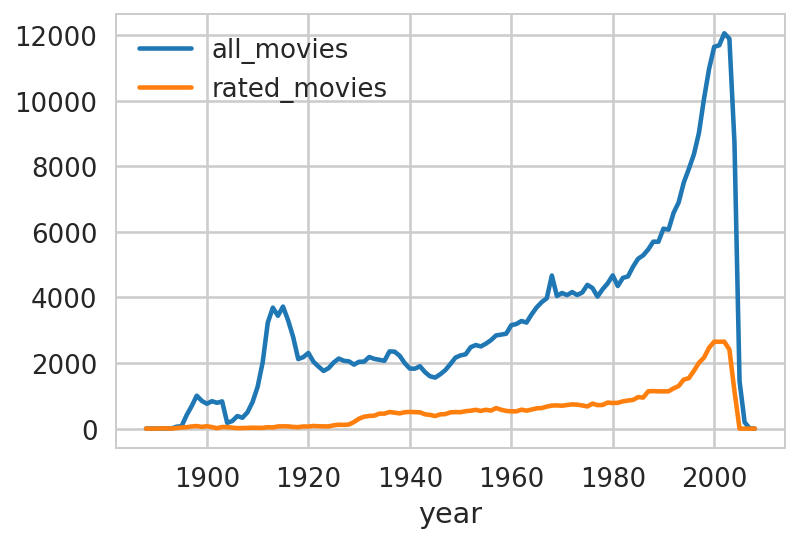

In [13]:
pivot.plot()

## Better option: Aggregation in SQL, fetch only necessary data

Now let's push the computation on the SQL server instead, using a GROUP BY and COUNT aggregates in SQL.

In [14]:
%%time
query = '''
SELECT year, COUNT(*) AS all_movies, COUNT(rank) AS rated_movies
FROM movies 
GROUP BY year
ORDER BY year
'''
df_movies = pd.read_sql(query, con=engine_imdb)

CPU times: user 698 µs, sys: 2.13 ms, total: 2.83 ms
Wall time: 289 ms


In [15]:
len(df_movies)

120

In [16]:
df_movies.sample(5)

,year,all_movies,rated_movies
37,1926,2137,119
85,1974,4151,707
118,2007,7,0
83,1972,4164,739
29,1918,2122,46


Notice that the same calculation was done in a few (4-5) **milliseconds**. The SQL query that we used earlier it took **seconds** to execute. In fact, the **pivot** table calculation, executed after fetching all the data took longer than executing the GROUPBY/COUNT SQL query and fetching the results.

While in this example the difference is negligible, once you deal with datasets that have millions, or tens of millions of rows, the savings become material and significant.

### Plotting: The importance of index

Let's try to plot the results. In pandas, the simple `plot()` command will use the index as the x-axis, and will plot all the numeric columns, as a line plot.

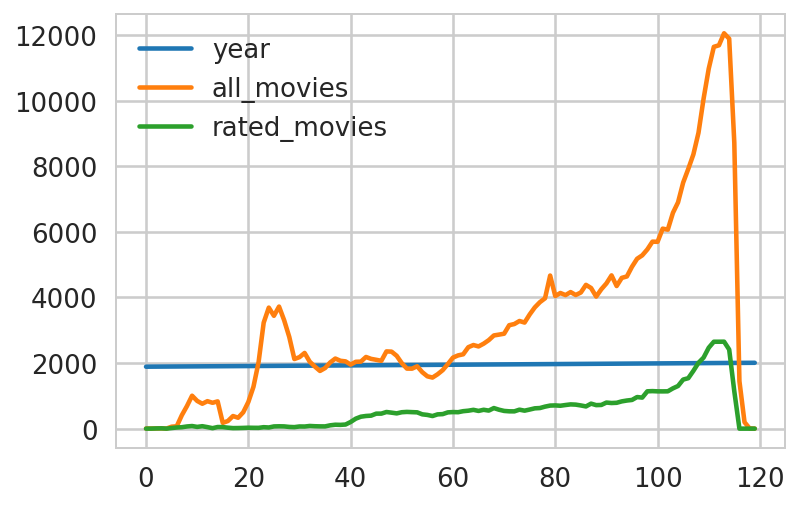

In [17]:
# The plot() command takes the index (the first "column") of the dataframe
# and makes that the x-axis.
# Then it plots *ALL* the numeric columns as a line
df_movies.plot()

We do not want to plot the `year` variable as a line. So, we select just the other two columns and plot.

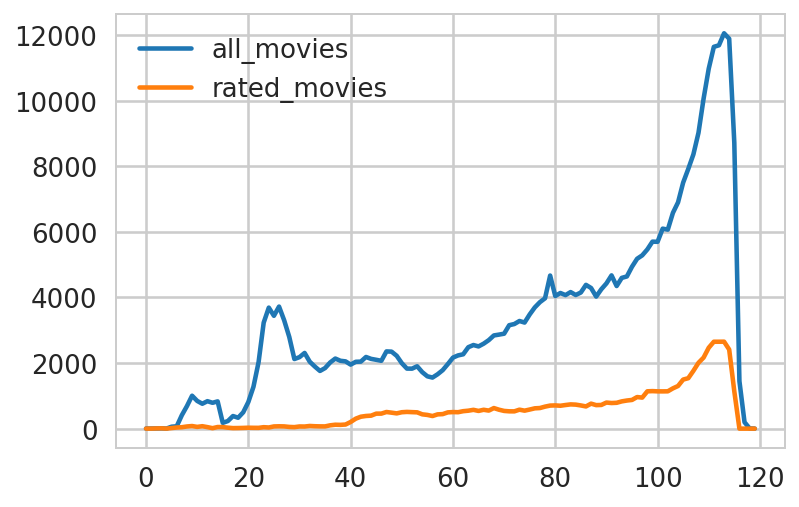

In [18]:
# First step: We can eliminate the "year" line by selecting 
# the columns that we want to plot
# To select columns, we pass a list of the column names that
# we want to keep in square brackets
df_movies[ ["all_movies", "rated_movies"] ].plot() 
# still the x-axis does not list the year

A bit better. `year` is not appearing anymore, but we still do not have `year` as the x-axis. 

To make `year` the x-axis, we need to make it the index of the dataframe:

In [19]:
df_movies_2 = df_movies.set_index('year')
df_movies_2.sample(5)

,all_movies,rated_movies
year,,
1963,3235,548
1906,384,16
1919,2180,66
1892,9,9
1957,2842,627


Now the plot has the year as the x-axis, and the labels are proper.

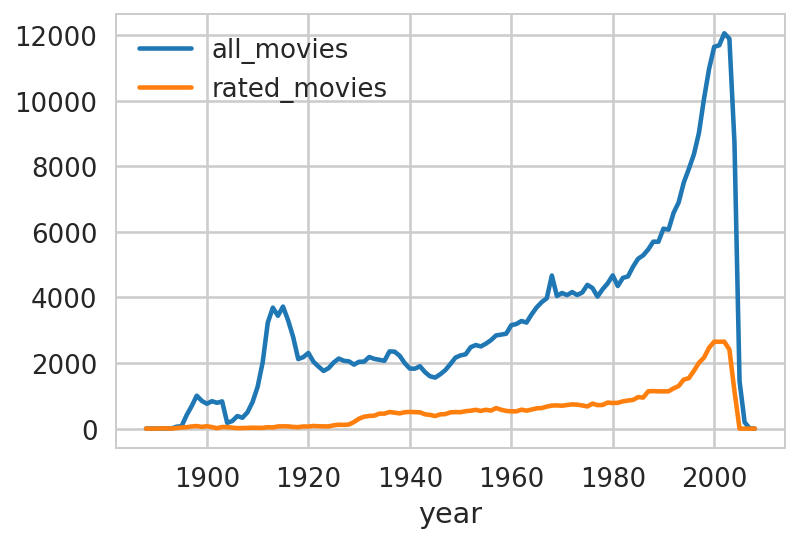

In [20]:
df_movies_2.plot()

### (Optional, but useful) Changing data types: Int vs Datetime

In our index above, the "year" variable is an integer:

In [21]:
df_movies_2.index.dtype

dtype('int64')

This is mostly fine, but we can leverage the time series processing capabilities of Pandas by converting `year` to a date.

In [22]:
# We first convert the index into datetime.
df_movies_2.index = pd.to_datetime(df_movies_2.index, format='%Y')

In [23]:
df_movies_2.sample(5)

,all_movies,rated_movies
year,,
1990-01-01,6098,1136
1899-01-01,845,53
1898-01-01,1004,79
1947-01-01,1784,443
1970-01-01,4136,698


Now we can do the `resample` the dates in the index. For example, we can compute numbers over decades:

In [24]:
df_movies_2.resample('10Y').sum()

,all_movies,rated_movies
year,,
1888-12-31,2,0
1898-12-31,2253,257
1908-12-31,5682,368
1918-12-31,26422,460
1928-12-31,20303,881
1938-12-31,21437,4027
1948-12-31,17843,4622
1958-12-31,25204,5527
1968-12-31,35435,5924


## Exercise

* Connect to the Facebook database, and use the `MemberSince` variable from the `Profiles` table to plot the growth of Facebook users. Use the following information:
>    user='student', 
>    password='dwdstudent2015', 
>    host = 'db.ipeirotis.org', 
>    port=3306, 
>    db='facebook'
* (_Learn something new_) Use the [cumsum()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.cumsum.html) function of Pandas and plot the total number of registered users over time.

### Solution

In [ ]:
conn_string_fb = 'mysql://{user}:{password}@{host}:{port}/{db}?charset=utf8'.format(
    user='student', 
    password='dwdstudent2015', 
    host = 'db.ipeirotis.org', 
    port=3306, 
    db='facebook',
    encoding = 'utf-8'
)
engine_fb = create_engine(conn_string_fb)

In [ ]:
%%time
# Naive approach, fetch all the data first
query = 'SELECT * FROM Profiles'
df = pd.read_sql(query, con=engine_fb)
pivot = df.pivot_table(
    index='MemberSince',
    values='ProfileID',
    aggfunc='count'    
)
# Calculate weekly signups
weekly_signups = pivot.resample('1W').sum()

In [ ]:
%%time
# Push calculations into SQL
query = 'SELECT MemberSince, COUNT(ProfileID) as signups FROM Profiles GROUP BY MemberSince'
df = pd.read_sql(query, con=engine_fb)
df.set_index("MemberSince", inplace=True)
weekly_signups = df.resample('1W').sum()

In [ ]:
weekly_signups.plot()

In [ ]:
df.cumsum().plot()

In [ ]:
# Raw numbers, by relationship status
pivot.plot(kind='barh', figsize=(10,5))

In [ ]:
# Raw numbers, by looking for (taking the transpose)
pivot.T.plot(kind='barh', figsize=(10,5))

In [ ]:
# Every column (LookingFor) sums up to 1
pivot / pivot.sum()

In [ ]:
# Every column (LookingFor) sums up to 1
(pivot / pivot.sum()).T

In [ ]:
(pivot / pivot.sum()).T.plot(kind='barh')

In [ ]:
# Every column (Relationship Status) sums up to 1
pivot.T / pivot.T.sum()